# Numenta Anomaly Benchmark

### Description

The datasets used in this notebook were gathered from the Kaggle datset: <a href=https://www.kaggle.com/datasets/boltzmannbrain/nab> Numenta Anomaly Benchmark (NAB)</a>. Each subfolder contains a timeseries-like dataset of real world/artificial anomaly observations.

The full description of each dataset can be found <a href=https://www.kaggle.com/datasets/boltzmannbrain/nab>here</a>.


### Purpose
The purpose of this notebook is to showcase various data processing and estimating techniques based on the NAB dataset. Timeseries forecasting and anomaly detection are closely related fields, both having enormous impact in the fields of finance and engineering.

---

## Table of contents
1. [Dataset](#1.0)
2. [Exploratory Data Analysis](#2.0)
3. [Refining the data](#3.0)
4. [Simple Regression](#4.0)
5. [DNN Regression](#5.0)
6. [XGBoost](#6.0)
7. [Model Comparison](#7.0)

#### But what is an anomaly?

According to this <a href=https://towardsdatascience.com/effective-approaches-for-time-series-anomaly-detection-9485b40077f1>Towards Data Science article: </a>:

> " ...a data point which is not following the common collective trend or seasonal or cyclic pattern of the entire data and is significantly distinct from rest of the data."

The 3 main approaches we can use to detect time-series anomalies are based on:

    1. Statistical estimation
    2. Unsupervised clustering
    3. ML algorithms

<a id="1.0"></a>

## 1. Dataset

#### 1.1 Visualization 
Since there are many data files with different patterns lets visualize a few of them.

For this notebook I chose a real dataset from TWITTER.

In [95]:
import os
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics import tsaplots
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
import tensorflow as tf
import seaborn as sns

In [84]:
NO_OF_PLOTS_SHOWN = 2

In [85]:
def plot_csv(path,nrows,ncols):
    fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(15,10))
    for i,f in enumerate(os.listdir(path)):
        df= pd.read_csv(path+f)
        if i < ncols:
            ax = axes[0,i]
        else:
            ax = axes[1,i-ncols]
        ax.plot(df["timestamp"], df["value"])
        ax.set_title(f[:-4])
        
        # axes.plot(x ="timestamp", y="value")
        

# path_art_anom = "data//realTweets//realTweets//"
# plot_csv(path_art_anom,2,5)
# df = pd.read_csv("data//artificialWithAnomaly//artificialWithAnomaly//art_daily_jumpsup.csv")

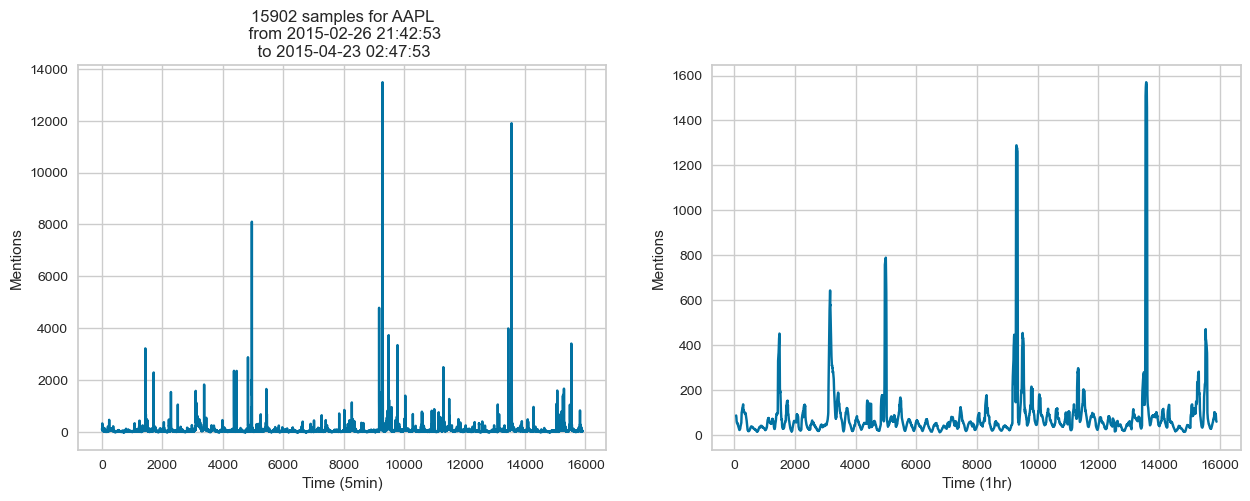

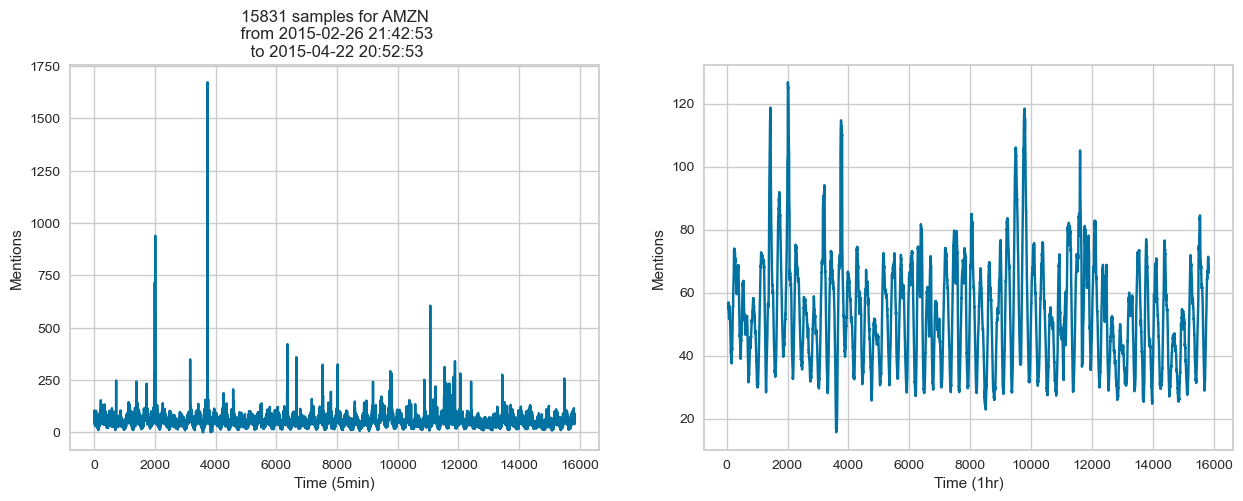

In [86]:
path = "data//realTweets//realTweets//"

for i,f in enumerate(os.listdir(path)[:NO_OF_PLOTS_SHOWN]):
    fig,ax = plt.subplots(1,2,figsize=(15,5))
    df = pd.read_csv(path+f)
    print()
    df["hr_avg"] = df['value'].rolling(window=60).mean()
    ax[0].plot(df["value"])
    ax[0].set_title("{} samples for {}\n from {}\n to {}".format(len(df),f.split("_")[2][:-4],min(df.timestamp),max(df.timestamp)))
    ax[0].set_xlabel("Time (5min)")
    ax[0].set_ylabel("Mentions")
    
    ax[1].plot(df["hr_avg"])
    #ax[1].title(f.split("_")[2][:-4])
    ax[1].set_xlabel("Time (1hr)")
    ax[1].set_ylabel("Mentions")
    
    

#### 1.2 Distribution of data (+Feature extraction)

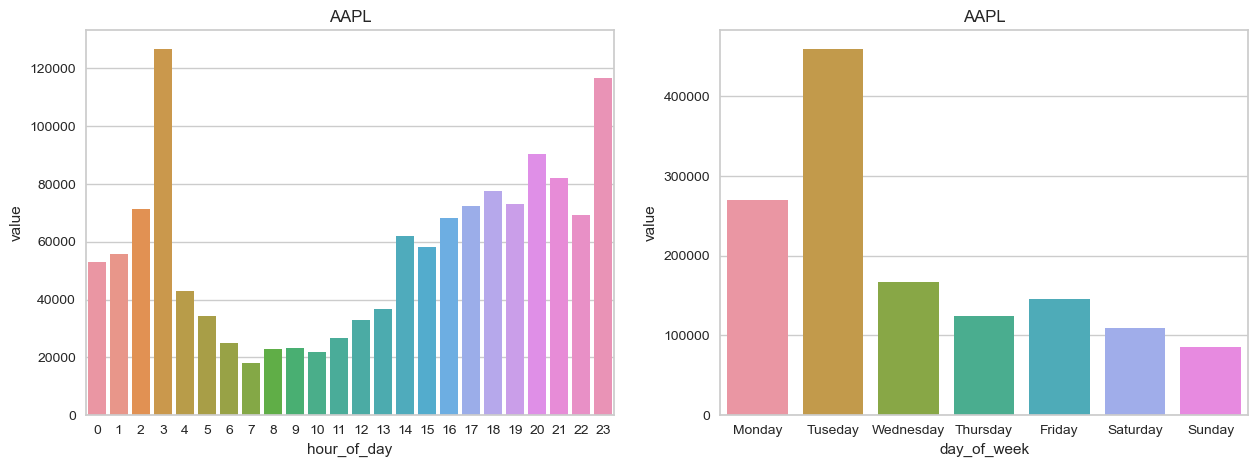

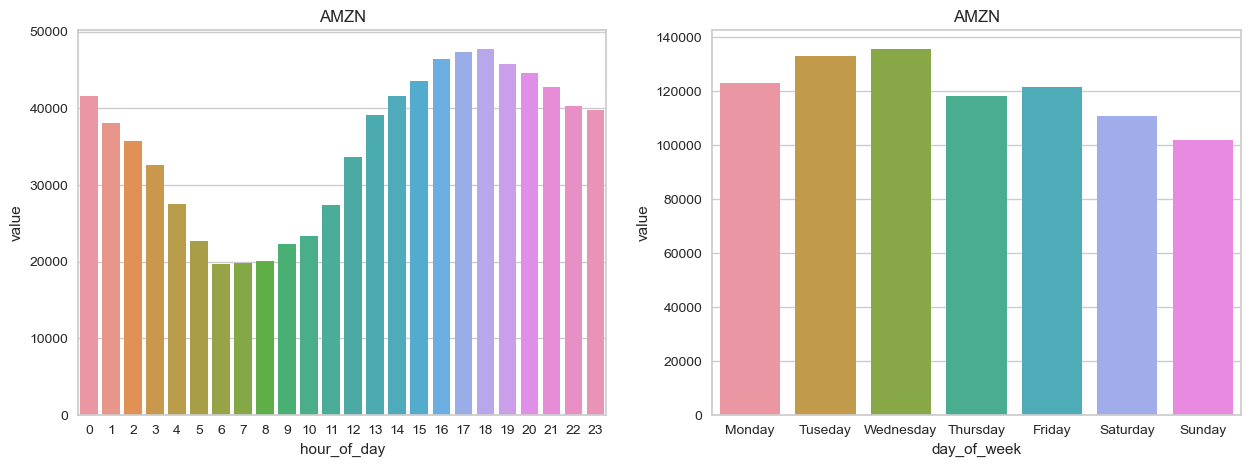

In [87]:
path = "data//realTweets//realTweets//"

for i,f in enumerate(os.listdir(path)[:NO_OF_PLOTS_SHOWN]):
    fig,ax = plt.subplots(1,2,figsize=(15,5))
    df = pd.read_csv(path+f)
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df["day_of_week"] = df["timestamp"].dt.weekday
    df["week_of_year"] =  df["timestamp"].dt.isocalendar().week
    df["hour_of_day"] = df["timestamp"].dt.hour

    sns.barplot(y = df.groupby(df["hour_of_day"]).sum(numeric_only=True)["value"],x=df.groupby(df["hour_of_day"]).sum(numeric_only=True).index,ax=ax[0])
    sns.barplot(y = df.groupby(df["day_of_week"]).sum(numeric_only=True)["value"],x=df.groupby(df["day_of_week"]).sum(numeric_only=True).index,ax=ax[1])
    ax[1].set_xticklabels(["Monday","Tuseday","Wednesday","Thursday","Friday","Saturday","Sunday"])
    ax[0].set_title(f.split("_")[2][:-4])
    ax[1].set_title(f.split("_")[2][:-4])
    #sns.displot(df["hr_avg"],ax=ax[1])
    

#### 1.3 Autocorrelation of signals

IndexError: list index out of range

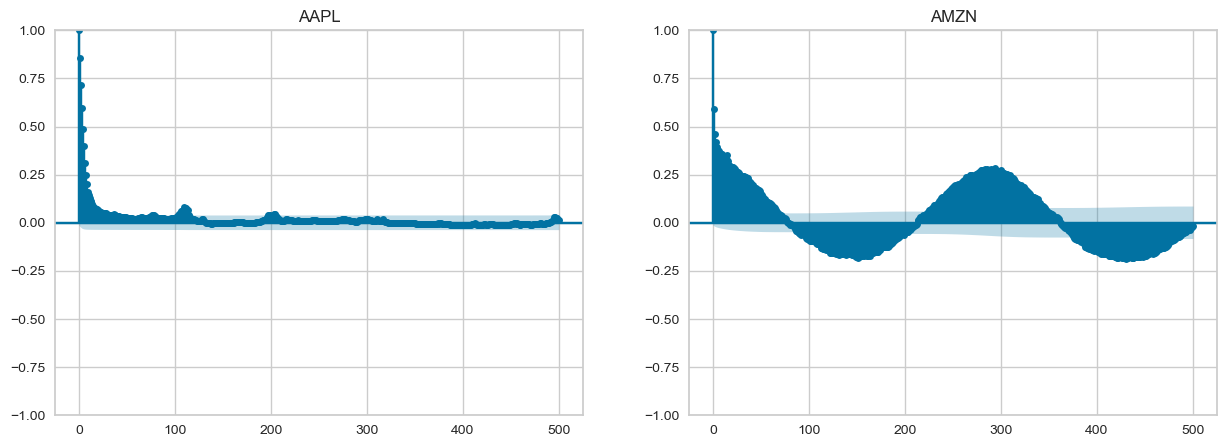

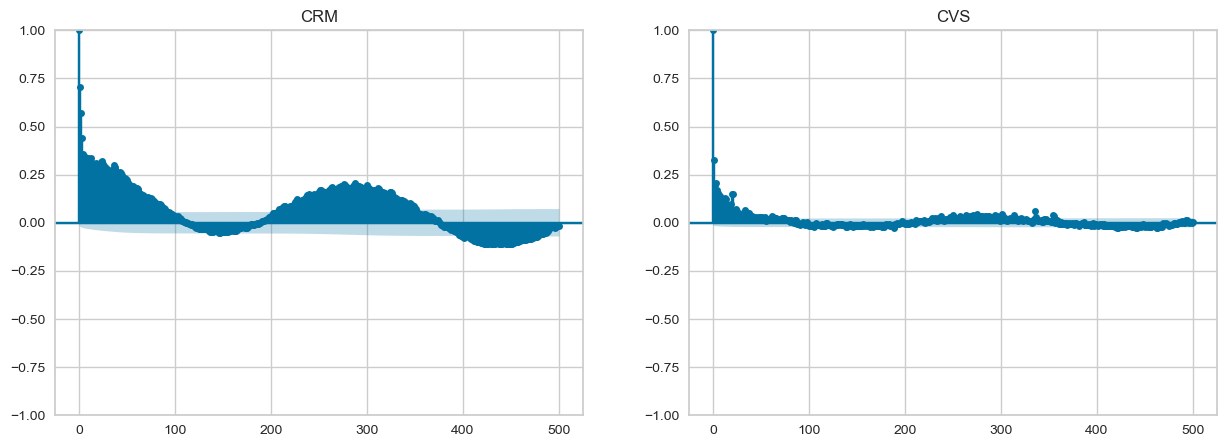

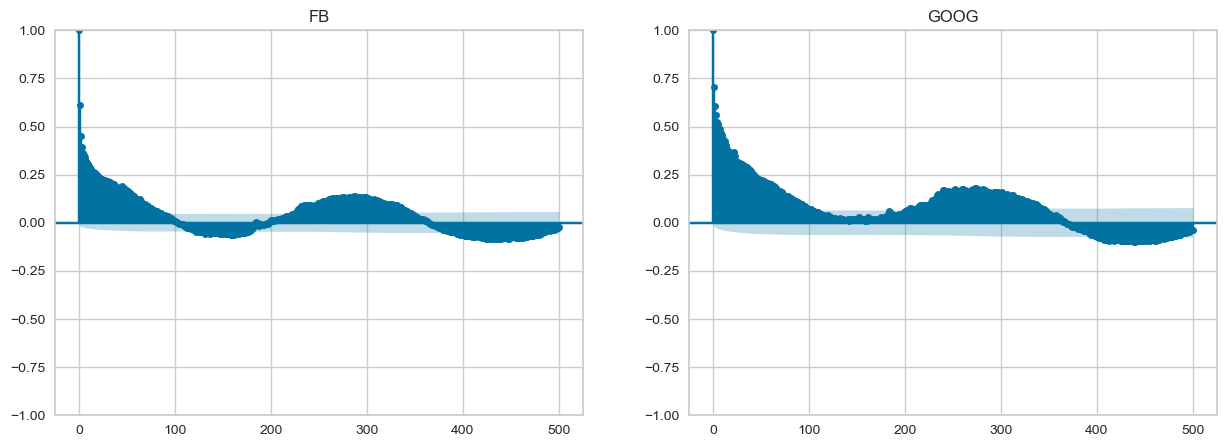

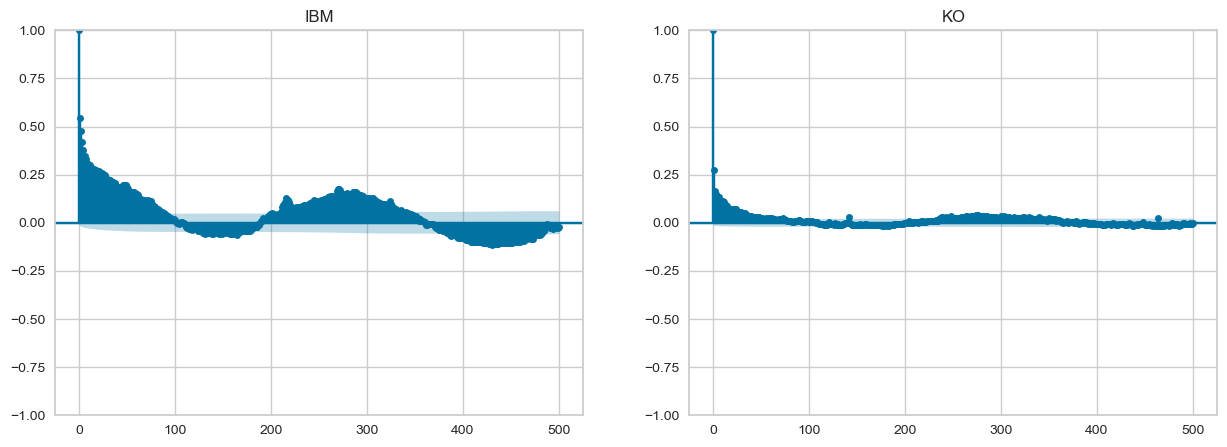

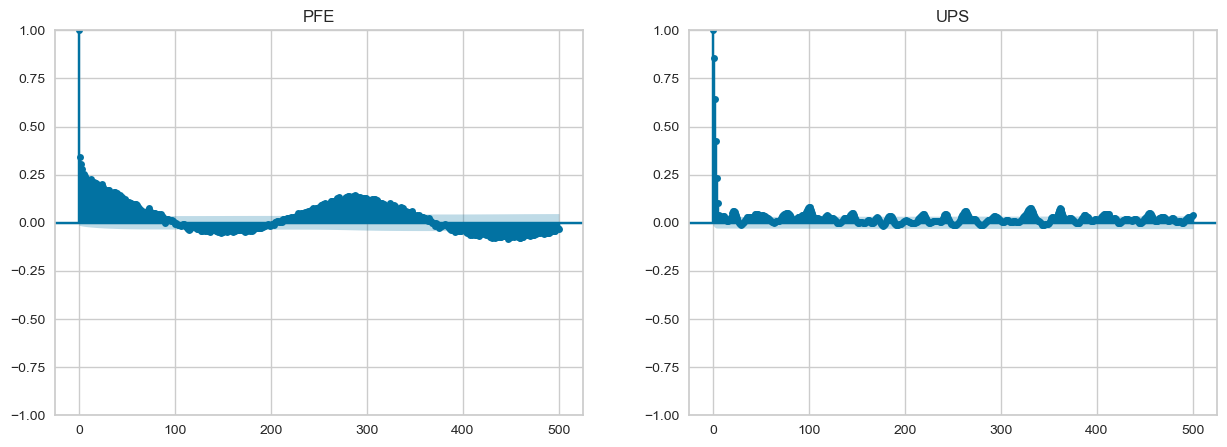

In [88]:
i = 0
for i in range(0,len(os.listdir(path)[NO_OF_PLOTS_SHOWN])-1,2):
    
    df1 = pd.read_csv(path+os.listdir(path)[i])
    df2 = pd.read_csv(path+os.listdir(path)[i+1])
    
    fig,ax = plt.subplots(1,2,figsize=(15,5))
    df = pd.read_csv(path+f)
    tsaplots.plot_acf(df1["value"], lags=500,ax=ax[0])
    tsaplots.plot_acf(df2["value"], lags=500,ax=ax[1])
    ax[0].set_title(os.listdir(path)[i].split("_")[2][:-4])
    ax[1].set_title(os.listdir(path)[i+1].split("_")[2][:-4])
    # plt.show()
    i += 2

## Clustering 

#### Standard Scaling variables

In [96]:
df = pd.read_csv(path+"Twitter_volume_AAPL.csv")

In [97]:
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["day_of_week"] = df["timestamp"].dt.weekday
df["week_of_year"] =  df["timestamp"].dt.isocalendar().week
df["hour_of_day"] = df["timestamp"].dt.hour

In [100]:
st_scaler = StandardScaler()
mm_scaler = MinMaxScaler()
pca = PCA(n_components=2)
norm_val = mm_scaler.fit_transform(df[["value","day_of_week","week_of_year","hour_of_day"]])
pca_mat = pca.fit_transform(norm_val)
pca_df = pd.DataFrame(pca_mat,columns=["feature1","feature2"])

Elbow Method to determine the number of clusters to be formed:


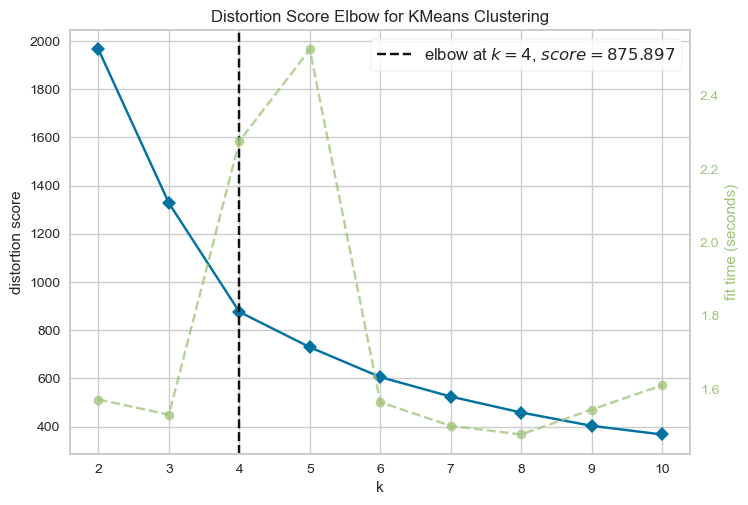

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [102]:
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(pca_df)
Elbow_M.show()

In [108]:
clf_kmeans = KMeans(n_clusters=4)

pca_df["cluster"] = clf_kmeans.fit_predict(pca_df)
print(pca_df)

       feature1  feature2  cluster
0      0.221604  0.432581        2
1      0.221607  0.432580        2
2      0.221608  0.432579        2
3      0.221573  0.432598        2
4      0.222150  0.476005        2
...         ...       ...      ...
15897 -0.221423 -0.432262        3
15898 -0.221423 -0.432262        3
15899 -0.221425 -0.432261        3
15900 -0.221411 -0.432268        3
15901 -0.221419 -0.432264        3

[15902 rows x 3 columns]


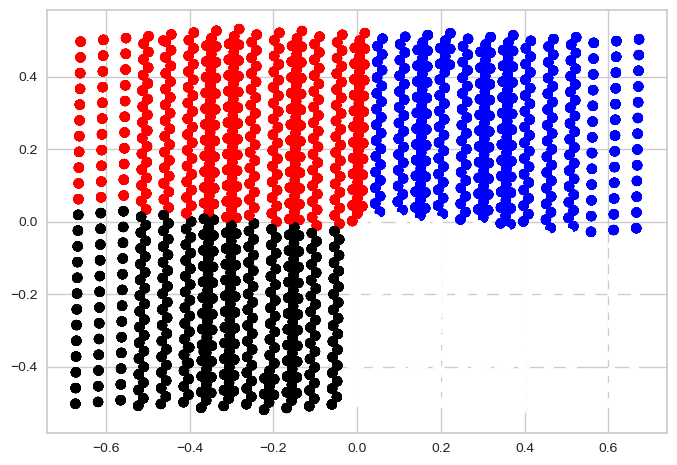

In [112]:
plt.scatter(pca_df["feature1"],pca_df["feature2"],c=pca_df["cluster"],cmap="flag")